### sky flux comparison
We compare the sky flux provided by Park to the sky flux generated using `specsim`

The sky flux from `specsim` is calculated as 

$$f(\lambda) = 10^{-e(\lambda) X /2.5} \left[a \times b(\lambda)\right]$$

The first part ($10^{-e(\lambda) X /2.5}$) is the extinction determined by the extinction coefficients and airmass. $a$ is the fiber area and $b(\lambda)$ is the surface brightness read in from precomputed values. 

In [5]:
import os
import h5py
import numpy as np
import astropy.units as u
# -- local --
import env
from feasibgs import util as UT

In [40]:
import desimodel.io
import desisim.simexp
import specsim.atmosphere
import specsim.instrument

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

First lets read in the sky fluxes provided by Parker

In [6]:
dark_sky = np.loadtxt(UT.dat_dir()+'sky/spec-sky.dat', unpack=True, skiprows=2, usecols=[0,1])

f = UT.dat_dir()+'sky/moon_sky_spectrum.hdf5'
assert os.path.isfile(f)
f_hdf5 = h5py.File(f, 'r')
ws, ss = [], [] 
for i in range(4): 
    ws.append(f_hdf5['sky'+str(i)+'/wave'].value)
    ss.append(f_hdf5['sky'+str(i)+'/sky'].value)
    
bright_sky0 = [10.*ws[2], ss[2]]
bright_sky1 = [10.*ws[3], ss[3]]

Here's what the sky fluxes look like

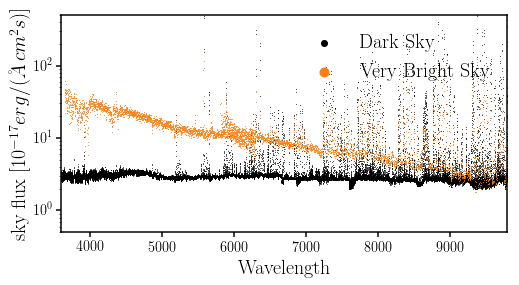

In [12]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(dark_sky[0], dark_sky[1], c='k', lw=0, s=0.5, label='Dark Sky')
sub.scatter(bright_sky0[0], bright_sky0[1], c='C1', lw=0, s=1., label='Very Bright Sky')
sub.scatter(bright_sky1[0], bright_sky1[1], c='C1', lw=0, s=1.)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky flux [$10^{-17} erg/(\AA\,cm^2s)$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 5e2])
sub.legend(loc='upper right', markerscale=10, prop={'size':20})

Now lets read in the different pre-computed surface brightnesses 

In [42]:
# ccd wavelength limit 
params = desimodel.io.load_desiparams() 
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']
print('%f < lambda < %f' % (wavemin, wavemax))

3533.000000 < lambda < 9913.000000


In [43]:
waves = dark_sky[0][(dark_sky[0] > wavemin) & (dark_sky[1] < wavemax)] * u.Angstrom
config = desisim.simexp._specsim_config_for_wave((waves).to('Angstrom').value, 
                                                 specsim_config_file='desi')

In [44]:
atm_config = config.atmosphere
print('impose extinction on sky flux: %r'% atm_config.extinct_emission)
print('sky condition: %s' % atm_config.sky.condition)
print('airmass: %f' % atm_config.airmass)

impose extinction on sky flux: True
sky condition: dark
airmass: 1.000000


In [45]:
surface_brightness_dict = config.load_table(atm_config.sky, 'surface_brightness', as_dict=True)

In [46]:
extinction_coefficient = config.load_table(atm_config.extinction, 'extinction_coefficient')

In [47]:
extinction = 10 ** (-extinction_coefficient * atm_config.airmass / 2.5)

In [57]:
print extinction

[0.58707096 0.58710395 0.58713699 ... 0.97732013 0.97808506 0.97844813]


Now we can compute 

$$10^{-e(\lambda) X /2.5} b(\lambda)$$

for $b(\lambda)$ in dark, grey, and bright conditions. We ignore the light scattered from the moon at this moment

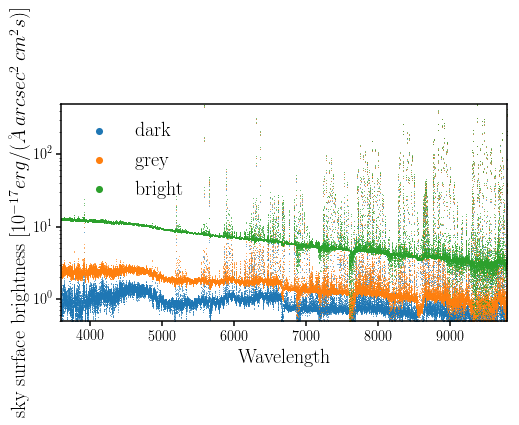

In [48]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for key in ['dark', 'grey', 'bright']: 
    sub.scatter(config.wavelength, extinction * surface_brightness_dict[key], lw=0, s=0.5, label=key)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky surface brightness [$10^{-17} erg/(\AA\,arcsec^2\,cm^2s)$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 5e2])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})

Fiber area calculated in the `Simulator.simulate` method

In [52]:
fiber_area = 1.90668697 * u.arcsec**2

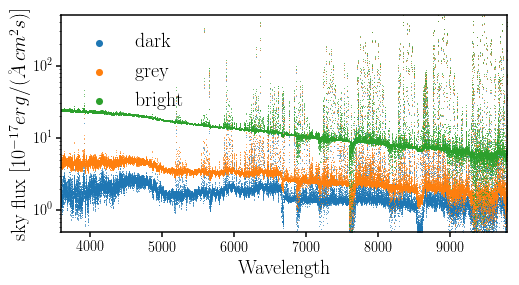

In [54]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for key in ['dark', 'grey', 'bright']: 
    sub.scatter(config.wavelength, extinction * fiber_area * surface_brightness_dict[key], lw=0, s=0.5, label=key)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky flux [$10^{-17} erg/(\AA\,cm^2s)$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 5e2])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})

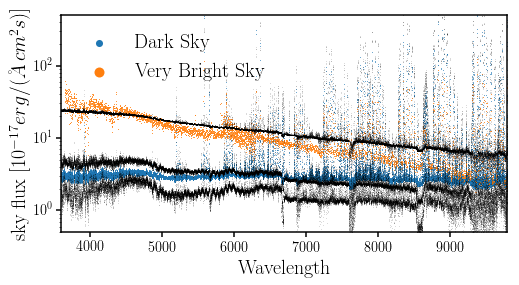

In [60]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(dark_sky[0], dark_sky[1], c='C0', lw=0, s=0.5, label='Dark Sky')
sub.scatter(bright_sky0[0], bright_sky0[1], c='C1', lw=0, s=1., label='Very Bright Sky')
sub.scatter(bright_sky1[0], bright_sky1[1], c='C1', lw=0, s=1.)

for key in ['dark', 'grey', 'bright']: 
    sub.scatter(config.wavelength, extinction * fiber_area * surface_brightness_dict[key], c='k', lw=0, s=0.1)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky flux [$10^{-17} erg/(\AA\,cm^2s)$]', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 5e2])
sub.legend(loc='upper left', markerscale=10, prop={'size':20})